# PCA算法
### 算法步骤：
设有n条d维的数据，  
1、将原始数据按照列组成n行d列的矩阵X；  
2、将X的每一列（代表一个属性）进行零均值化，即减去这一列的均值；  
3、求出协方差矩阵：C = sum{(xi - X_mean)transpose((xi - X_mean)};    
4、求出C的特征值并按从大到小进行排序：[lambda1, lambda2, ..., lambdaM, lambdaM+1, ...],  
   对应的特征向量[transpose(a1), transpose(a2), transpose(a3), ..., transpose(aM), transpose(aM+1), ...]；  
5、归一化所有a[i], 使得a[i]和a[i]的转置相乘=1；  
6、Y = A(xi - X_mean)   

PS：推荐一个讲的比较好的博客：http://blog.codinglabs.org/articles/pca-tutorial.html

In [329]:
#!/usr/bin/env python
# encoding: utf-8
'''
@author: Bin GAO
@license: (C) Copyright 2013-2018, Node Supply Chain Manager Corporation Limited.
@contact: bin.gao@outlook.com
@software: garner
@file: test.py
@time: 2020-04-11 11:10
@desc:
'''

import os, sys
import numpy as np
from matplotlib import pyplot as plt
from scipy import io as spio

In [330]:
# 1.对所有样本进行中心化（所有样本属性减去属性的平均值）
def featureNormailze(dataMat):
    n_shape = dataMat.shape[1]
    meanValue = np.mean(dataMat, axis=0)
    dataMatNorm = dataMat - meanValue
    
    return dataMatNorm, meanValue

In [331]:
# 2.计算样本的协方差矩阵 sigma = XTX
def covMatrix(dataMatNorm):
    # n_shape = dataMat.shape[1]
    # Sigma = np.covMatrixt(np.transpose(dataMat), dataMat) / n_shape
    Sigma = np.cov(dataMatNorm, rowvar=0)   # rowvar:默认为True,此时每一行代表一个变量（属性），每一列代表一个观测；为False时，则反之
    covMat = Sigma
    return covMat

In [332]:
# 3.对协方差矩阵做特征值分解，求得其特征值和特征向量，并将特征值从大到小排序，筛选出前topNfeat个
def eigen(meanValue, dataMatNorm, covMat, top_n):
    # 特征值从大到小排列，并求出相应的特征向量
    eigenValues, eigenVectors = np.linalg.eig(np.mat(covMat))
    # 取前topNfeat大的特征值的索引
    eigenValuesInd = np.argsort(eigenValues)[:-(top_n+1):-1]
    # 取前topNfeat大的特征值所对应的特征向量
    eigenVectorsInd = eigenVectors[:, eigenValuesInd]
    print('eigenVectorsInd', eigenVectorsInd)
    
    # 数据降维之后的新数据Y
    lowDataMat = dataMatNorm * eigenVectorsInd
    
    # 恢复数据
    recoMat = (lowDataMat * eigenValuesInd.T) + meanValue
      
    return np.array(lowDataMat), np.array(recoMat)

#  也可以用SVD分解来做
def eigen_SVD(covMat):
    U, S, V = np.linalg.svd(covMat)
    return U, S, V

In [333]:
def PCA_2d():
    dataMat = spio.loadmat("./data/data.mat")
    dataMat = dataMat['X']
    m = dataMat.shape[0]
    
    print("原始数据")
    plt = plot_data_2d(dataMat,'bo') # 显示二维的数据
    plt.show()
    
    # 显示归一化后的数据
    dataMatCopy = dataMat.copy()
    dataMatNorm, meanValue = featureNormailze(dataMatCopy)
    print("归一化后数据")
    pltNorm = plot_data_2d(dataMatNorm, 'bo')    # 显示归一化后的数据
    pltNorm.show()
    
    # 求sigma
    covMat = covMatrix(dataMatNorm)
    #print(Sigma)
    #lowDataMat, recoMat = eigen(meanValue, dataMatNorm, covMat, top_n=1)
    
    U, S, V = eigen_SVD(covMat)
    print(U)
    plt = plot_data_2d(dataMat,'bo') # 显示原本数据
    drawline(plt, meanValue, meanValue+S[0]*(U[:,0]), 'r-')  # 线，为投影的方向
    plt.axis('square')
    plt.show()
    
    K = 1  # 定义降维多少维（本来是2维的，这里降维1维）
    '''投影之后数据（降维之后）'''
    Z = projectData(dataMatNorm,U,K)   # 投影
    '''恢复数据'''
    recoMat = recoverData(Z,U,K)    # 恢复
    '''作图-----原数据与恢复的数据'''
    plt = plot_data_2d(dataMatNorm,'bo')
    plot_data_2d(recoMat,'ro')
    for i in range(dataMatNorm.shape[0]):
        drawline(plt, dataMatNorm[i,:], recoMat[i,:], '--k')
    plt.axis('square')
    plt.show()

In [334]:
def PCA_image():
    dataMat = spio.loadmat("./data/data_faces.mat")
    dataMat = dataMat['X']
    print("原始数据")
    display_imageData(dataMat[0:100,:])
    m = dataMat.shape[0]  # 数据条数
    
    
    # 使用PCA对图像降维
    dataMatCopy = dataMat.copy()
    dataMatNorm, meanValue = featureNormailze(dataMatCopy)
    # 求sigma
    covMat = covMatrix(dataMatNorm)
    U, S, V = eigen_SVD(covMat)
    
    display_imageData(np.transpose(U[:,0:36]))     # 显示U的数据
    K = 10     # 降维10维(原先是32*32=1024维的)
    Z = projectData(dataMatNorm, U, K)
    
    print("PCA后的数据")
    recoMat = recoverData(Z, U, K) # 恢复数据
    display_imageData(recoMat[0:100,:])

In [335]:
# 可视化二维数据
def plot_data_2d(X,marker):
    plt.plot(X[:,0],X[:,1],marker) 
    return plt

# 显示图片
def display_imageData(imgData):
    sum = 0
    '''
    显示100个数（若是一个一个绘制将会非常慢，可以将要画的图片整理好，放到一个矩阵中，显示这个矩阵即可）
    - 初始化一个二维数组
    - 将每行的数据调整成图像的矩阵，放进二维数组
    - 显示即可
    '''
    m,n = imgData.shape
    width = np.int32(np.round(np.sqrt(n)))
    height = np.int32(n/width);
    rows_count = np.int32(np.floor(np.sqrt(m)))
    cols_count = np.int32(np.ceil(m/rows_count))
    pad = 1
    display_array = -np.ones((pad+rows_count*(height+pad),pad+cols_count*(width+pad)))
    for i in range(rows_count):
        for j in range(cols_count):
            max_val = np.max(np.abs(imgData[sum,:]))
            display_array[pad+i*(height+pad):pad+i*(height+pad)+height,pad+j*(width+pad):pad+j*(width+pad)+width] = imgData[sum,:].reshape(height,width,order="F")/max_val    # order=F指定以列优先，在matlab中是这样的，python中需要指定，默认以行
            sum += 1
            
    plt.imshow(display_array,cmap='gray')   #显示灰度图像
    plt.axis('off')
    plt.show()
   
# 画一条线
def drawline(plt,p1,p2,line_type):
    plt.plot(np.array([p1[0],p2[0]]),np.array([p1[1],p2[1]]),line_type) 
    
# 映射数据
def projectData(X_norm,U,K):
    Z = np.zeros((X_norm.shape[0],K))
    
    U_reduce = U[:,0:K]          # 取前K个
    Z = np.dot(X_norm,U_reduce) 
    return Z

# 恢复数据
def recoverData(Z,U,K):
    X_rec = np.zeros((Z.shape[0],U.shape[0]))
    U_recude = U[:,0:K]
    X_rec = np.dot(Z,np.transpose(U_recude))  # 还原数据（近似）
    return X_rec

原始数据


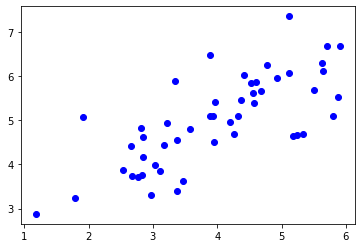

归一化后数据


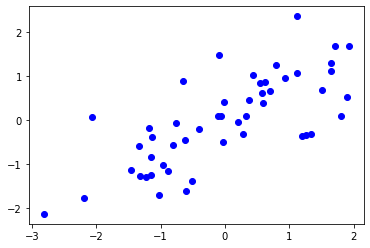

[[-0.76908153 -0.63915068]
 [-0.63915068  0.76908153]]


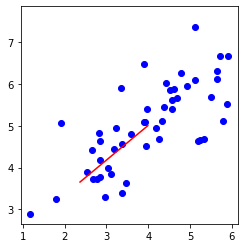

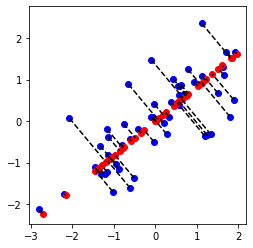

原始数据


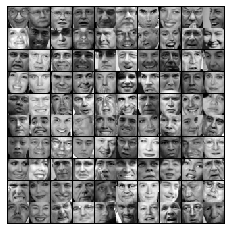

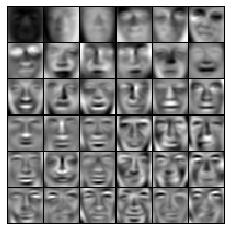

PCA后的数据


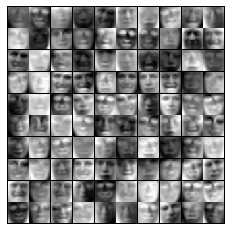

In [336]:
if __name__ == "__main__":
    PCA_2d()
    PCA_image()